# Proyecto final de imágenes
**Integrantes: Nicolás Becerra, Marcelo Rojas**

## Paquetes

In [40]:
# Paquetes utils
import matplotlib.pyplot as plt
import cv2
import os
import imutils
import numpy as np

In [43]:
# Paquetes pytorch
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [111]:
# # Paquetes keras
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import itertools

## Carga de imágenes

In [2]:
folder = '/Users/marcelo/Downloads/Semestre otoño 2023/Lab. Inteligencia/proyecto_final/' # Carpeta en donde se encuentran las carpetas de los dataset

In [3]:
def load_images_from_folder(folder):
    """" Función que carga todas las imágenes de una carpeta"""
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), 0)
        if img is not None:
            images.append([img,filename])
    return images

In [5]:
# Cargar dataset gpr1200
gpr1200 = load_images_from_folder(folder+'GPR1200')

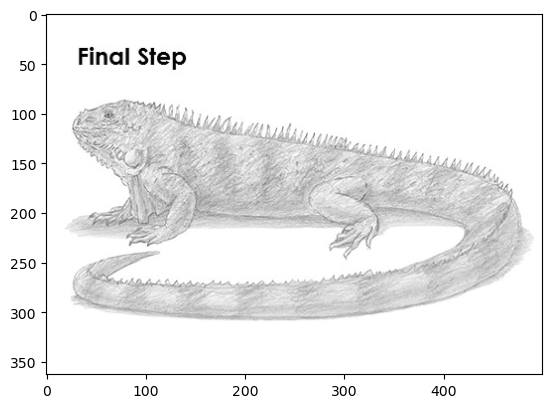

In [33]:
# Ejemplo gpr1200
sample = gpr1200[13][0]
plt.imshow(sample, cmap=plt.get_cmap('gray'))

## Método handcrafted

In [20]:
def LBP(img):
  """Función para obtener el LBP de una imágen"""
  X = img.shape[0]-2
  Y = img.shape[1]-2
  img_lbp = np.zeros((X,Y))
  for x in range(X):
    for y in range(Y):
      pix = ''
      for i, j in [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]:
        if img[x+1,y+1]<=img[x+1+i,y+1+j]:
          pix+='0'
        else:
          pix+='1'
      img_lbp[x][y]=int(pix,2)
  return img_lbp

In [22]:
def hist(img):
  """Función para obtener el histograma de una imágen en escala de grises"""
  hist = np.array([])
  for i in range(5):
    for j in range(5):
      x, y = (i+1)*100, (j+1)*120
      img_w = img[:x-1][:y-1].ravel()
      window_hist = plt.hist(img_w, bins = 59, range= (0,255.0))
      window_hist = window_hist[0]
      hist = np.concatenate((hist, window_hist), axis = None)
  return hist

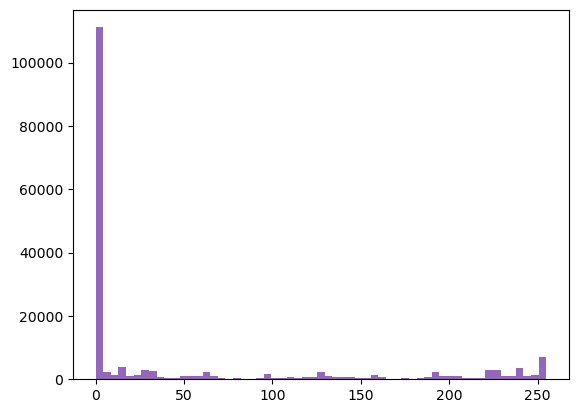

In [147]:
# Ejemplo handcrafted
lbp = LBP(sample)
histo = hist(lbp)

## Resnet

In [67]:
# Load the pretrained model
model = models.resnet18(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

/Users/marcelo/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcelo/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
# Set model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## VGG

In [117]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
# Get VGG-16 Model
def getVGG16Model(lastFourTrainable=False):
  vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=True)

  # Make all layers untrainable
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = vgg_model.get_layer('fc2').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=10, activation='softmax')(output)
  vgg_model = Model(vgg_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    vgg_model.get_layer('block5_conv3').trainable = True
    vgg_model.get_layer('fc1').trainable = True
    vgg_model.get_layer('fc2').trainable = True
    vgg_model.get_layer('new_fc').trainable = True

  # Compile VGG-16 model
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model

In [145]:
# Get feature vector of an image by given model and img_path
def getFeatureVector(model, img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  feature_vector = model.predict(img.reshape(1, 224, 224, 3))
  return feature_vector

In [119]:
vgg_model_a = getVGG16Model(lastFourTrainable=False)
feature_model_vgg_a = Model(inputs=vgg_model_a.input, outputs=vgg_model_a.get_layer('new_fc').output)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Ejemplos vgg

1/1 [==============================] - 0s 241ms/step


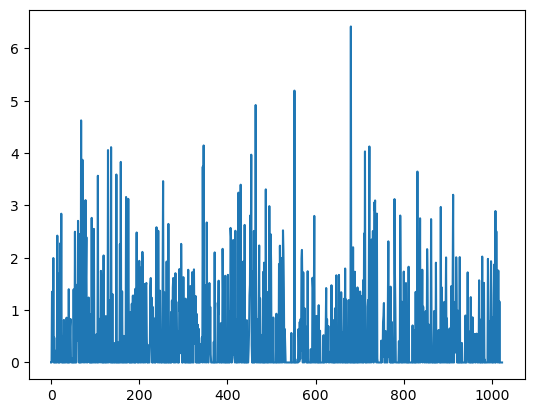

In [146]:
sample_vec = getFeatureVector(feature_model_vgg_a, '/Users/marcelo/Downloads/Semestre otoño 2023/Lab. Inteligencia/proyecto_final/GPR1200/0_8c54ccf63a12ee74.jpg')
plt.plot(sample_vec[0])

1/1 [==============================] - 0s 127ms/step


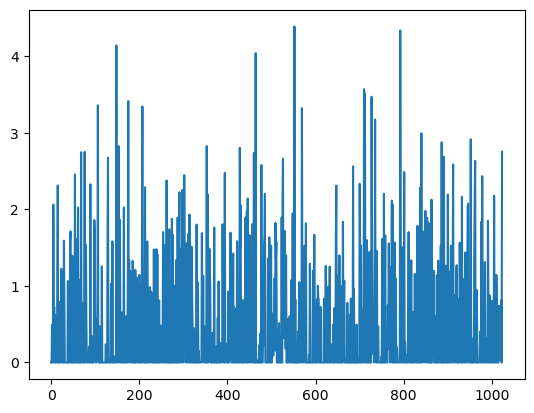

In [139]:
sample_vec = getFeatureVector(feature_model_vgg_a, '/Users/marcelo/Downloads/Semestre otoño 2023/Lab. Inteligencia/proyecto_final/GPR1200/0_430b273cb7915d83.jpg')
plt.plot(sample_vec[0])

1/1 [==============================] - 0s 129ms/step


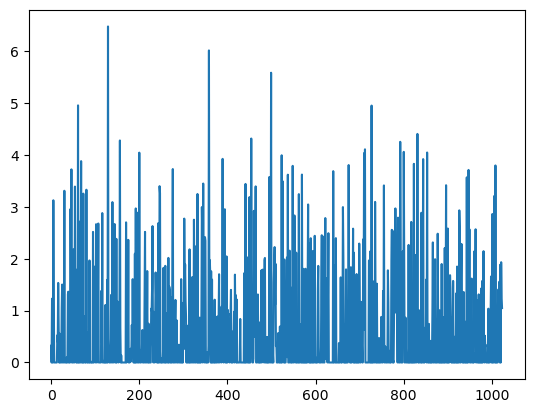

In [140]:
sample_vec = getFeatureVector(feature_model_vgg_a, '/Users/marcelo/Downloads/Semestre otoño 2023/Lab. Inteligencia/proyecto_final/GPR1200/1_7ccb9b5a7059b82d.jpg')
plt.plot(sample_vec[0])

1/1 [==============================] - 0s 150ms/step


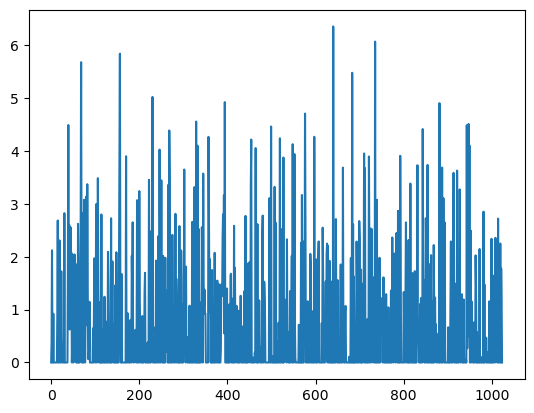

In [142]:
sample_vec = getFeatureVector(feature_model_vgg_a, '/Users/marcelo/Downloads/Semestre otoño 2023/Lab. Inteligencia/proyecto_final/GPR1200/1_02b09bb030cf5687.jpg')
plt.plot(sample_vec[0])

## Juntar métodos

In [ ]:
def char_vec(img, metodo):
    if metodo == 'hc':
        lbp = LBP(img)
        histo = hist(lbp)
        return histo
    elif metodo == 'cnn':
        return

In [ ]:
char_vec(sample, 'hc')